Tune CLAHE round 1
==

In [ ]:
pip install scikit-video


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.7 MB/s eta 0:00:00


In [ ]:
pip install sewar


  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11419 sha256=39ee8a56f8c7cdd8dcee6c18f700c6d3cefaa408d0ca733857af403f883f93e0
  Stored in directory: /root/.cache/pip/wheels/3f/af/02/9c6556ba287b62a945d737def09b8b8c35c9e1d82b9dfae84c
Successfully built sewar


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
#from sewar.full_ref import uqi
from sewar.full_ref import vifp
import pandas as pd
from google.colab.patches import cv2_imshow  # Import for displaying images

class ImageEnhancementResult:
    def __init__(self, clipLimit, tileGridSize, avg_contrast_value, avg_brightness_value, avg_entropy_value, avg_vif_value):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        self.avg_contrast_value = avg_contrast_value
        self.avg_brightness_value = avg_brightness_value
        self.avg_entropy_value = avg_entropy_value
        self.avg_vif_value = avg_vif_value

    def to_dict(self):
        return {
            'Clip Limit': self.clipLimit,
            'Tile Grid Size': f'{self.tileGridSize[0]}x{self.tileGridSize[1]}',
            'Avg Contrast': self.avg_contrast_value,
            'Avg Brightness': self.avg_brightness_value,
            'Avg Entropy': self.avg_entropy_value,
            'Avg VIF': self.avg_vif_value
        }

def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        histogram[pixel] += 1
    return histogram

def calculate_entropy(img):
  entrophies = []
  for i in range(3):
    Y = img[:,:,i]
    hist, _ = np.histogram(Y.flatten(), bins=256, range=(0, 256))
    pdf = hist / hist.sum()
    # Remove zero probabilities to avoid log(0)
    pdf = pdf[pdf > 0]

    # Calculate entropy
    entropy = -np.sum(pdf * np.log2(pdf))
    entrophies.append(entropy)

  return np.mean(entrophies)


def apply_clahe(image, clipLimit, tileGridSize):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    return clahe.apply(image)

def enhance_color_image_clahe(image, clipLimit, tileGridSize):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = apply_clahe(img_yuv[:, :, 0], clipLimit, tileGridSize)
    enhanced_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return enhanced_img

def calculate_psnr(original, comparison):
    mse = np.mean((original - comparison) ** 2, axis=(0, 1, 2))
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_ssim(original, comparison):
    ssim_values = []
    for i in range(original.shape[2]):
        ssim_channel = ssim(original[:, :, i], comparison[:, :, i], data_range=comparison[:, :, i].max() - comparison[:, :, i].min())
        ssim_values.append(ssim_channel)
    return np.mean(ssim_values)

def calculate_vif(original, comparison):
    return vifp(original, comparison)

def c_contrast(image):
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = image_ycbcr[:, :, 0]
    Y_array = np.array(Y)
    norm = Y_array / 255
    return np.std(norm)

def calculate_absolute_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

listNames = ['sample01.jpg', 'sample02.jpeg', 'sample03.jpeg', 'sample04.jpeg', 'sample05.jpeg', 'sample06.jpg', 'sample07.jpg', 'sample08.jpg']
clipLimitlist = [ 2,4,6,8]
#tileGridSizelist = [(9,9),(12,12), (14,14),(16,16), (20,20)]
tileGridSizelist = [(8,8),(16,16), (20,20),(32,32)]

# List to store results
average_results = []

# Loop through the clipLimits and tileGridSizes
for clipLimit in clipLimitlist:
    for tileGridSize in tileGridSizelist:
        total_entropy = 0
        total_vif = 0
        total_contrast = 0
        total_brightness = 0
        for name in listNames:
            original_img = cv2.imread('/content/drive/MyDrive/sampleimages/' + name)
            enhanced_img_clahe = enhance_color_image_clahe(original_img, clipLimit, tileGridSize)
            oe = calculate_entropy(original_img)
            ee = calculate_entropy(enhanced_img_clahe)

            entropy_value_clahe = ee/oe
            vif_value_clahe = calculate_vif(original_img, enhanced_img_clahe)
            contrast_value_clahe = c_contrast(enhanced_img_clahe)
            brightness_value_clahe = calculate_absolute_brightness(enhanced_img_clahe)

            total_entropy += entropy_value_clahe
            total_vif += vif_value_clahe
            total_contrast += contrast_value_clahe
            total_brightness += brightness_value_clahe

            # Display the original and enhanced images
            #print(f'Displaying original image: {name}')
            #cv2_imshow(original_img)

            #print(f'Displaying enhanced image for ClipLimit={clipLimit} and TileGridSize={tileGridSize}')
            #cv2_imshow(enhanced_img_clahe)

        avg_entropy = total_entropy / len(listNames)
        avg_vif = total_vif / len(listNames)
        avg_contrast = total_contrast / len(listNames)
        avg_brightness = total_brightness / len(listNames)

        # Store the average results
        average_result = ImageEnhancementResult(clipLimit, tileGridSize, avg_contrast, avg_brightness, avg_entropy, avg_vif)
        average_results.append(average_result)

# Create a DataFrame to display results in a table format
df = pd.DataFrame([result.to_dict() for result in average_results])

# Print the DataFrame
print(df)


    Clip Limit Tile Grid Size  Avg Contrast  Avg Brightness  Avg Entropy  \
0            2            8x8      0.201752      136.816754     1.115410   
1            2          16x16      0.174379      145.098188     1.037365   
2            2          20x20      0.184681      140.721298     1.069310   
3            2          32x32      0.197994      137.149965     1.087019   
4            4            8x8      0.226955      135.526242     1.162529   
5            4          16x16      0.209304      138.785604     1.131279   
6            4          20x20      0.206581      138.411520     1.127116   
7            4          32x32      0.200192      140.450757     1.118113   
8            6            8x8      0.243022      134.409473     1.185465   
9            6          16x16      0.227240      135.565086     1.164289   
10           6          20x20      0.220818      136.790123     1.155405   
11           6          32x32      0.206870      141.872513     1.132505   
12          

In [ ]:
# Define the path where the Excel file will be saved
excel_file_path = '/content/drive/MyDrive/enhancedimages/enhancement_results.xlsx'

# Save the DataFrame to an Excel file
df.to_excel(excel_file_path, index=False)


CLAHE team member choosing time!
==

In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
from sewar.full_ref import vifp
import pandas as pd
from google.colab.patches import cv2_imshow  # Import for displaying images

class ImageEnhancementResult:
    def __init__(self, clipLimit, tileGridSize, avg_contrast_value, avg_brightness_value, avg_entropy_value, avg_vif_value):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        self.avg_contrast_value = avg_contrast_value
        self.avg_brightness_value = avg_brightness_value
        self.avg_entropy_value = avg_entropy_value
        self.avg_vif_value = avg_vif_value

    def to_dict(self):
        return {
            'Clip Limit': self.clipLimit,
            'Tile Grid Size': f'{self.tileGridSize[0]}x{self.tileGridSize[1]}',
            'Avg Contrast': self.avg_contrast_value,
            'Avg Brightness': self.avg_brightness_value,
            'Avg Entropy': self.avg_entropy_value,
            'Avg VIF': self.avg_vif_value
        }

def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        histogram[pixel] += 1
    return histogram

def calculate_entropy(img):
  entrophies = []
  for i in range(3):
    Y = img[:,:,i]
    hist, _ = np.histogram(Y.flatten(), bins=256, range=(0, 256))
    pdf = hist / hist.sum()
    # Remove zero probabilities to avoid log(0)
    pdf = pdf[pdf > 0]

    # Calculate entropy
    entropy = -np.sum(pdf * np.log2(pdf))
    entrophies.append(entropy)

  return np.mean(entrophies)

def apply_clahe(image, clipLimit, tileGridSize):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    return clahe.apply(image)

def enhance_color_image_clahe(image, clipLimit, tileGridSize):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = apply_clahe(img_yuv[:, :, 0], clipLimit, tileGridSize)
    enhanced_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return enhanced_img

def calculate_psnr(original, comparison):
    mse = np.mean((original - comparison) ** 2, axis=(0, 1, 2))
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_ssim(original, comparison):
    ssim_values = []
    for i in range(original.shape[2]):
        ssim_channel = ssim(original[:, :, i], comparison[:, :, i], data_range=comparison[:, :, i].max() - comparison[:, :, i].min())
        ssim_values.append(ssim_channel)
    return np.mean(ssim_values)

def calculate_vif(original, comparison):
    return vifp(original, comparison)

def c_contrast(image):
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = image_ycbcr[:, :, 0]
    Y_array = np.array(Y)
    norm = Y_array / 255
    return np.std(norm)

def calculate_absolute_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

listNames = ['sample01.jpg', 'sample02.jpeg', 'sample03.jpeg', 'sample04.jpeg', 'sample05.jpeg', 'sample06.jpg', 'sample07.jpg', 'sample08.jpg']
clipLimitlist = [2, 3]
tileGridSizelist = [(8, 8)]

# List to store results
average_results = []

# Loop through the clipLimits and tileGridSizes
for clipLimit in clipLimitlist:
    for tileGridSize in tileGridSizelist:
        total_entropy = 0
        total_vif = 0
        total_contrast = 0
        total_brightness = 0
        for name in listNames:
            original_img = cv2.imread('/content/drive/MyDrive/sampleimages/' + name)
            enhanced_img_clahe = enhance_color_image_clahe(original_img, clipLimit, tileGridSize)


            oe = calculate_entropy(original_img)
            ee = calculate_entropy(enhanced_img_clahe)

            entropy_value_clahe = ee/oe
            vif_value_clahe = calculate_vif(original_img, enhanced_img_clahe)
            contrast_value_clahe = c_contrast(enhanced_img_clahe)
            brightness_value_clahe = calculate_absolute_brightness(enhanced_img_clahe)

            total_entropy += entropy_value_clahe
            total_vif += vif_value_clahe
            total_contrast += contrast_value_clahe
            total_brightness += brightness_value_clahe

            # Generate filenames based on enhancement parameters
            base_name, ext = name.split('.')
            enhanced_filename = f'/content/drive/MyDrive/enhancedimages/{base_name}_clipLimit{clipLimit}_tileGridSize{tileGridSize[0]}x{tileGridSize[1]}.{ext}'

            # Save the enhanced image
            cv2.imwrite(enhanced_filename, enhanced_img_clahe)

        avg_entropy = total_entropy / len(listNames)
        avg_vif = total_vif / len(listNames)
        avg_contrast = total_contrast / len(listNames)
        avg_brightness = total_brightness / len(listNames)

        # Store the average results
        average_result = ImageEnhancementResult(clipLimit, tileGridSize, avg_contrast, avg_brightness, avg_entropy, avg_vif)
        average_results.append(average_result)

# Create a DataFrame to display results in a table format
df = pd.DataFrame([result.to_dict() for result in average_results])

# Print the DataFrame
print(df)


   Clip Limit Tile Grid Size  Avg Contrast  Avg Brightness  Avg Entropy  \
0           2            8x8      0.201752      136.816754     1.115410   
1           3            8x8      0.215812      136.111449     1.143537   

    Avg VIF  
0  0.956551  
1  0.911954  


GHE Baseline HE
==
Convert RGB to YUV

1 Produce a Histogram of the raw input image

2 Calculate the mapping function for HE, normalise the Histogram

3 HE the pixels

Convert YUV to RGB

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        histogram[pixel] += 1
    return histogram

def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf_normalized = cdf * (255 / cdf[-1])
    return cdf_normalized.astype('uint8')

def apply_histogram_equalization(image, cdf):
    return cdf[image]

def histogram_equalization(image):
    histogram = calculate_histogram(image)
    cdf = calculate_cdf(histogram)
    return apply_histogram_equalization(image, cdf)

def enhance_color_image(image):
    # Convert the image from BGR to YUV
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = histogram_equalization(img_yuv[:, :, 0])
    enhanced_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return enhanced_img

def plot_histogram(image, title, filename):
    plt.figure()
    plt.hist(image.flatten(), bins=256, range=[0, 256], color='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.savefig(filename)
    plt.close()
def calculate_vif(original, comparison):
    return vifp(original, comparison)

def c_contrast(image):
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = image_ycbcr[:, :, 0]
    Y_array = np.array(Y)
    norm = Y_array / 255
    return np.std(norm)

def calculate_absolute_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

# Define a function to save images
def save_image(image, filename):
    cv2.imwrite(filename, image)

def calculate_entropy(img):
  entrophies = []
  for i in range(3):
    Y = img[:,:,i]
    hist, _ = np.histogram(Y.flatten(), bins=256, range=(0, 256))
    pdf = hist / hist.sum()
    # Remove zero probabilities to avoid log(0)
    pdf = pdf[pdf > 0]

    # Calculate entropy
    entropy = -np.sum(pdf * np.log2(pdf))
    entrophies.append(entropy)

  return np.mean(entrophies)


class ImageEnhancementResultHEBaseline:
    def __init__(self, avg_contrast_value, avg_brightness_value, avg_entropy_value, avg_vif_value):
        self.avg_contrast_value = avg_contrast_value
        self.avg_brightness_value = avg_brightness_value
        self.avg_entropy_value = avg_entropy_value
        self.avg_vif_value = avg_vif_value

    def to_dict(self):
        return {
            'Avg Contrast': self.avg_contrast_value,
            'Avg Brightness': self.avg_brightness_value,
            'Avg Entropy': self.avg_entropy_value,
            'Avg VIF': self.avg_vif_value
        }

listNames = ['sample01.jpg', 'sample02.jpeg', 'sample03.jpeg', 'sample04.jpeg', 'sample05.jpeg', 'sample06.jpg', 'sample07.jpg', 'sample08.jpg']

# Create a directory to save images and histograms
save_dir = '/content/drive/MyDrive/enhancedimages2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

total_entropy = 0
total_vif = 0
total_contrast = 0
total_brightness = 0

# List to store results
average_resultsGHE = []

for name in listNames:
    original_img = cv2.imread('/content/drive/MyDrive/sampleimages/' + name)

    # Apply manual HE to the image
    enhanced_img = enhance_color_image(original_img)

    oe = calculate_entropy(original_img)
    ee = calculate_entropy(enhanced_img)

    entropy_value_clahe = ee/oe
    vif_value_clahe = calculate_vif(original_img, enhanced_img)
    contrast_value_clahe = c_contrast(enhanced_img)
    brightness_value_clahe = calculate_absolute_brightness(enhanced_img)


    total_entropy += entropy_value_clahe
    total_vif += vif_value_clahe
    total_contrast += contrast_value_clahe
    total_brightness += brightness_value_clahe

    # Convert the images to grayscale for histogram plotting
    gray_original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    gray_enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)


avg_entropy = total_entropy / len(listNames)
avg_vif = total_vif / len(listNames)
avg_contrast = total_contrast / len(listNames)
avg_brightness = total_brightness / len(listNames)

# Store the average results
average_resultGHE = ImageEnhancementResultHEBaseline(avg_contrast, avg_brightness, avg_entropy, avg_vif)
average_resultsGHE.append(average_resultGHE)

# Create a DataFrame to display results in a table format
dfghe = pd.DataFrame([result.to_dict() for result in average_resultsGHE])

# Print the DataFrame
print(dfghe)

   Avg Contrast  Avg Brightness  Avg Entropy   Avg VIF
0      0.296226       131.79478     1.138139  0.753653


In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        histogram[pixel] += 1
    return histogram

def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf_normalized = cdf * (255 / cdf[-1])
    return cdf_normalized.astype('uint8')

def apply_histogram_equalization(image, cdf):
    return cdf[image]

def histogram_equalization(image):
    histogram = calculate_histogram(image)
    cdf = calculate_cdf(histogram)
    return apply_histogram_equalization(image, cdf)

def enhance_color_image(image):
    # Convert the image from BGR to YUV
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = histogram_equalization(img_yuv[:, :, 0])
    enhanced_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return enhanced_img

# New function to calculate pixel value stats
def get_pixel_value_stats(image):
    min_val = image.min()
    max_val = image.max()
    pixel_range = max_val - min_val
    return min_val, max_val, pixel_range

def plot_histogram(image, title, filename):
    min_val, max_val, pixel_range = get_pixel_value_stats(image)
    plt.figure()
    plt.hist(image.flatten(), bins=256, range=[0, 256], color='black', alpha=0.7)
    plt.title(f"{title}\nMin Pixel Value: {min_val}, Max Pixel Value: {max_val}, Range: {pixel_range}")
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.savefig(filename)
    plt.close()

def calculate_vif(original, comparison):
    return vifp(original, comparison)

def c_contrast(image):
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = image_ycbcr[:, :, 0]
    Y_array = np.array(Y)
    norm = Y_array / 255
    return np.std(norm)

def calculate_absolute_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

# Define a function to save images
def save_image(image, filename):
    cv2.imwrite(filename, image)

def calculate_entropy(img):
    entrophies = []
    for i in range(3):
        Y = img[:, :, i]
        hist, _ = np.histogram(Y.flatten(), bins=256, range=(0, 256))
        pdf = hist / hist.sum()
        pdf = pdf[pdf > 0]
        entropy = -np.sum(pdf * np.log2(pdf))
        entrophies.append(entropy)
    return np.mean(entrophies)

class ImageEnhancementResultHEBaseline:
    def __init__(self, avg_contrast_value, avg_brightness_value, avg_entropy_value, avg_vif_value):
        self.avg_contrast_value = avg_contrast_value
        self.avg_brightness_value = avg_brightness_value
        self.avg_entropy_value = avg_entropy_value
        self.avg_vif_value = avg_vif_value

    def to_dict(self):
        return {
            'Avg Contrast': self.avg_contrast_value,
            'Avg Brightness': self.avg_brightness_value,
            'Avg Entropy': self.avg_entropy_value,
            'Avg VIF': self.avg_vif_value
        }

listNames = ['sample01.jpg', 'sample02.jpeg', 'sample03.jpeg', 'sample04.jpeg', 'sample05.jpeg', 'sample06.jpg', 'sample07.jpg', 'sample08.jpg']

# Create a directory to save images and histograms
save_dir = '/content/drive/MyDrive/enhancedimages2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

total_entropy = 0
total_vif = 0
total_contrast = 0
total_brightness = 0

# List to store results
average_resultsGHE = []

for name in listNames:
    original_img = cv2.imread('/content/drive/MyDrive/sampleimages/' + name)

    # Apply manual HE to the image
    enhanced_img = enhance_color_image(original_img)

    # Convert images to grayscale for histogram plotting
    gray_original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    gray_enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Save the original and enhanced histograms
    plot_histogram(gray_original_img, f'Original Histogram: {name}', f"{save_dir}hist_original_{name}.png")
    plot_histogram(gray_enhanced_img, f'Enhanced Histogram (HE): {name}', f"{save_dir}hist_enhanced_{name}.png")

    # Add your metrics calculation code here as needed

# At the end, your calculated average results can be stored and displayed.


In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os

# New function to calculate pixel value stats
def get_pixel_value_stats(image):
    min_val = image.min()
    max_val = image.max()
    pixel_range = max_val - min_val
    return min_val, max_val, pixel_range

def plot_histogram(image, title, filename):
    min_val, max_val, pixel_range = get_pixel_value_stats(image)
    plt.figure()
    plt.hist(image.flatten(), bins=256, range=[0, 256], color='black', alpha=0.7)
    plt.title(f"{title}\nMin Pixel Value: {min_val}, Max Pixel Value: {max_val}, Range: {pixel_range}")
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.savefig(filename)
    plt.close()

def calculate_vif(original, comparison):
    return vifp(original, comparison)

def c_contrast(image):
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = image_ycbcr[:, :, 0]
    Y_array = np.array(Y)
    norm = Y_array / 255
    return np.std(norm)

def calculate_absolute_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

# Define a function to save images
def save_image(image, filename):
    cv2.imwrite(filename, image)

def calculate_entropy(img):
    entrophies = []
    for i in range(3):
        Y = img[:, :, i]
        hist, _ = np.histogram(Y.flatten(), bins=256, range=(0, 256))
        pdf = hist / hist.sum()
        pdf = pdf[pdf > 0]
        entropy = -np.sum(pdf * np.log2(pdf))
        entrophies.append(entropy)
    return np.mean(entrophies)

# Function to apply CLAHE
def apply_CLAHE(image):
    # Convert the image to the LAB color space
    lab_img = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_img)

    # Apply CLAHE to the L-channel (luminance channel)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L-channel back with A and B channels
    enhanced_lab_img = cv2.merge((cl, a_channel, b_channel))

    # Convert back to BGR color space
    enhanced_img = cv2.cvtColor(enhanced_lab_img, cv2.COLOR_LAB2BGR)
    return enhanced_img

listNames = ['sample01.jpg', 'sample02.jpeg', 'sample03.jpeg', 'sample04.jpeg', 'sample05.jpeg', 'sample06.jpg', 'sample07.jpg', 'sample08.jpg']

# Create a directory to save images and histograms
save_dir = '/content/drive/MyDrive/enhancedimages2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

total_entropy = 0
total_vif = 0
total_contrast = 0
total_brightness = 0

# List to store results
average_resultsCLAHE = []

for name in listNames:
    original_img = cv2.imread('/content/drive/MyDrive/sampleimages/' + name)

    # Apply CLAHE to the image
    enhanced_img = apply_CLAHE(original_img)

    # Convert images to grayscale for histogram plotting
    gray_original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    gray_enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Save the original and enhanced histograms
    #plot_histogram(gray_original_img, f'Original Histogram: {name}', f"{save_dir}hist_original_{name}.png")
    #plot_histogram(gray_enhanced_img, f'Enhanced Histogram (CLAHE): {name}', f"{save_dir}hist_enhanced_{name}.png")

    # Save the enhanced image
    save_image(enhanced_img, f"{save_dir}enhanced_CLAHE_{name}.jpg")

# Your calculated average results can be stored and displayed.


In [ ]:
# Define the path where the Excel file will be saved
excel_file_path = '/content/drive/MyDrive/enhancedimages2/enhancement_results.xlsx'

# Save the DataFrame to an Excel file
dfghe.to_excel(excel_file_path, index=False)


Original images metrics
==

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        histogram[pixel] += 1
    return histogram

def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf_normalized = cdf * (255 / cdf[-1])
    return cdf_normalized.astype('uint8')

def apply_histogram_equalization(image, cdf):
    return cdf[image]

def histogram_equalization(image):
    histogram = calculate_histogram(image)
    cdf = calculate_cdf(histogram)
    return apply_histogram_equalization(image, cdf)

def enhance_color_image(image):
    # Convert the image from BGR to YUV
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = histogram_equalization(img_yuv[:, :, 0])
    enhanced_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return enhanced_img

def plot_histogram(image, title, filename):
    plt.figure()
    plt.hist(image.flatten(), bins=256, range=[0, 256], color='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.savefig(filename)
    plt.close()
def calculate_vif(original, comparison):
    return vifp(original, comparison)

def c_contrast(image):
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y = image_ycbcr[:, :, 0]
    Y_array = np.array(Y)
    norm = Y_array / 255
    return np.std(norm)

def calculate_absolute_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

# Define a function to save images
def save_image(image, filename):
    cv2.imwrite(filename, image)

def calculate_entropy(img):
  entrophies = []
  for i in range(3):
    Y = img[:,:,i]
    hist, _ = np.histogram(Y.flatten(), bins=256, range=(0, 256))
    pdf = hist / hist.sum()
    # Remove zero probabilities to avoid log(0)
    pdf = pdf[pdf > 0]

    # Calculate entropy
    entropy = -np.sum(pdf * np.log2(pdf))
    entrophies.append(entropy)

  return np.mean(entrophies)

class ImageEnhancementResultHEBaseline:
    def __init__(self, avg_contrast_value, avg_brightness_value, avg_entropy_value, avg_vif_value):
        self.avg_contrast_value = avg_contrast_value
        self.avg_brightness_value = avg_brightness_value
        self.avg_entropy_value = avg_entropy_value
        self.avg_vif_value = avg_vif_value

    def to_dict(self):
        return {
            'Avg Contrast': self.avg_contrast_value,
            'Avg Brightness': self.avg_brightness_value,
            'Avg Entropy': self.avg_entropy_value,
            'Avg VIF': self.avg_vif_value
        }

listNames = ['sample01.jpg', 'sample02.jpeg', 'sample03.jpeg', 'sample04.jpeg', 'sample05.jpeg', 'sample06.jpg', 'sample07.jpg', 'sample08.jpg']

# Create a directory to save images and histograms
save_dir = '/content/drive/MyDrive/enhancedimages2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

total_entropy = 0
total_vif = 0
total_contrast = 0
total_brightness = 0

# List to store results
average_resultsOri = []

for name in listNames:
    original_img = cv2.imread('/content/drive/MyDrive/sampleimages/' + name)

    vif_value_clahe = calculate_vif(original_img, original_img)
    contrast_value_clahe = c_contrast(original_img)
    brightness_value_clahe = calculate_absolute_brightness(original_img)
    oe = calculate_entropy(original_img)
    ee = calculate_entropy(original_img)

    entropy_value_clahe = ee/oe
    total_entropy += entropy_value_clahe
    total_vif += vif_value_clahe
    total_contrast += contrast_value_clahe
    total_brightness += brightness_value_clahe


avg_entropy = total_entropy / len(listNames)
avg_vif = total_vif / len(listNames)
avg_contrast = total_contrast / len(listNames)
avg_brightness = total_brightness / len(listNames)

# Store the average results
average_resultOri = ImageEnhancementResultHEBaseline(avg_contrast, avg_brightness, avg_entropy, avg_vif)
average_resultsOri.append(average_resultOri)

# Create a DataFrame to display results in a table format
dfori = pd.DataFrame([result.to_dict() for result in average_resultsOri])

# Print the DataFrame
print(dfori)

   Avg Contrast  Avg Brightness  Avg Entropy  Avg VIF
0      0.165279      136.319149          1.0      1.0


Colour wheel
==

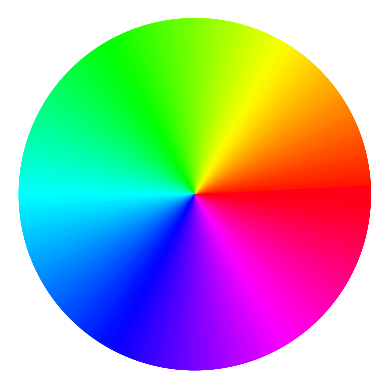

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a color wheel
def generate_color_wheel():
    # Create figure and axis
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Number of colors in the wheel
    n_colors = 360

    # Create an array of angles from 0 to 2*pi
    angles = np.linspace(0, 2 * np.pi, n_colors)

    # Create the radius array (constant)
    radius = np.ones(n_colors)

    # Generate HSV colors (hue, saturation, value)
    hsv_colors = np.zeros((n_colors, 3))
    hsv_colors[:, 0] = angles / (2 * np.pi)  # Hue
    hsv_colors[:, 1] = 1  # Saturation
    hsv_colors[:, 2] = 1  # Value (brightness)

    # Convert HSV to RGB using matplotlib's hsv_to_rgb
    rgb_colors = plt.cm.hsv(hsv_colors[:, 0])

    # Plot the color wheel
    bars = ax.bar(angles, radius, color=rgb_colors, width=0.1, edgecolor='none')

    # Remove axis labels
    ax.set_axis_off()

    # Display the color wheel
    plt.show()

# Call the function to generate the color wheel
generate_color_wheel()
